In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-prediction/seattle-weather.csv


In [2]:
# load dataset
data = pd.read_csv("/kaggle/input/weather-prediction/seattle-weather.csv")
data

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


# Data Preprocessing

In [3]:
data.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [4]:
data

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


In [5]:
# Count the occurrences of each weather category in the 'weather' column
data["weather"].value_counts()

weather
rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: count, dtype: int64

# Data visualization

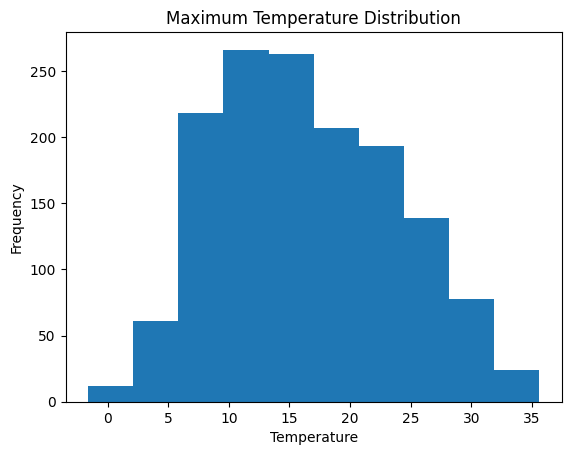

In [6]:
plt.hist(data['temp_max'])
plt.title('Maximum Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

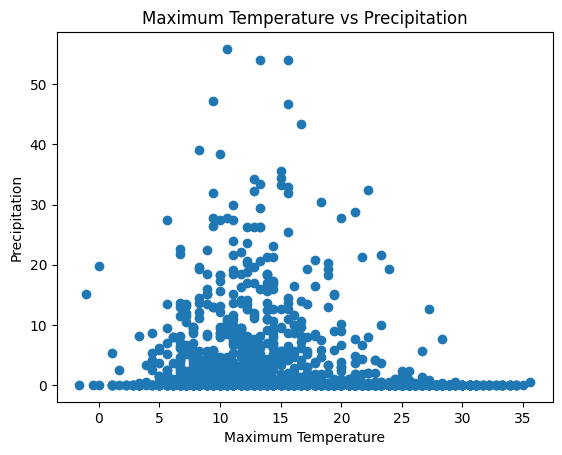

In [7]:
plt.scatter(data['temp_max'], data['precipitation'])
plt.title('Maximum Temperature vs Precipitation')
plt.xlabel('Maximum Temperature')
plt.ylabel('Precipitation')
plt.show()

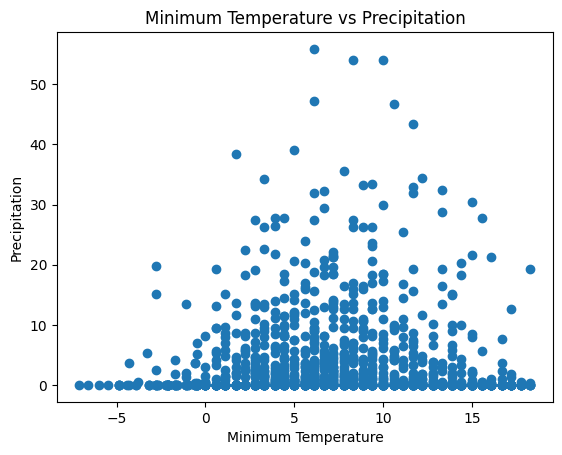

In [8]:
plt.scatter(data['temp_min'], data['precipitation'])
plt.title('Minimum Temperature vs Precipitation')
plt.xlabel('Minimum Temperature')
plt.ylabel('Precipitation')
plt.show()

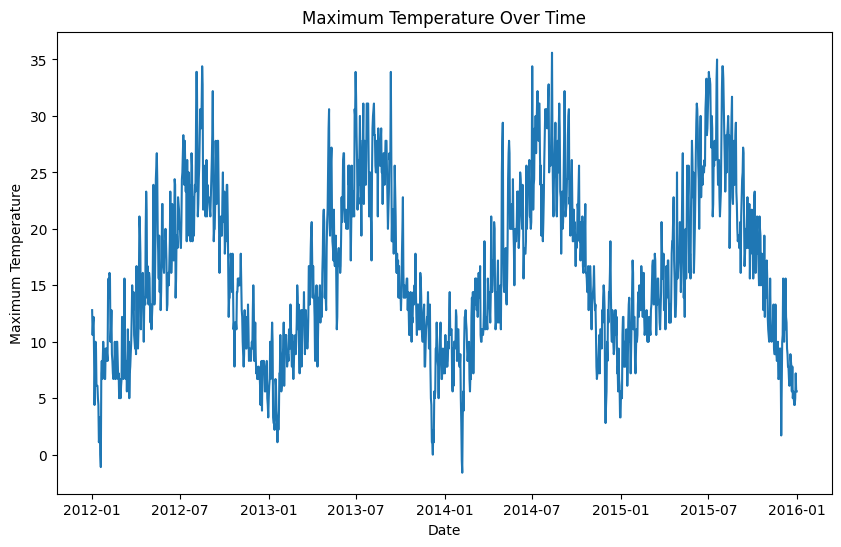

In [9]:
data['date'] = pd.to_datetime(data['date'])
plt.figure(figsize=(10,6))
plt.plot(data['date'], data['temp_max'])
plt.title('Maximum Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')

plt.show()


# Feature Engineering

In [10]:
# Check the data type of the 'date' column
print(data['date'].dtypes)

# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract year, month, and day features
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day


datetime64[ns]


In [11]:
# Display information about the DataFrame after modifications
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1461 non-null   datetime64[ns]
 1   precipitation  1461 non-null   float64       
 2   temp_max       1461 non-null   float64       
 3   temp_min       1461 non-null   float64       
 4   wind           1461 non-null   float64       
 5   weather        1461 non-null   object        
 6   year           1461 non-null   int32         
 7   month          1461 non-null   int32         
 8   day            1461 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(3), object(1)
memory usage: 85.7+ KB


In [12]:
data

,date,precipitation,temp_max,temp_min,wind,weather,year,month,day
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle,2012,1,1
1,2012-01-02,10.9,10.6,2.8,4.5,rain,2012,1,2
2,2012-01-03,0.8,11.7,7.2,2.3,rain,2012,1,3
3,2012-01-04,20.3,12.2,5.6,4.7,rain,2012,1,4
4,2012-01-05,1.3,8.9,2.8,6.1,rain,2012,1,5
...,...,...,...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain,2015,12,27
1457,2015-12-28,1.5,5.0,1.7,1.3,rain,2015,12,28
1458,2015-12-29,0.0,7.2,0.6,2.6,fog,2015,12,29
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun,2015,12,30


In [13]:
le = LabelEncoder()

data['weather_label'] = le.fit_transform(data['weather'])

In [14]:
# Create a dictionary mapping weather labels to weather values
weather_dict = {label: value for label, value in zip(data['weather_label'], data['weather'])}


In [15]:
# Drop the 'weather' column and set 'date' as the index in one line
data = data.drop('weather', axis=1).set_index('date')

# Display the first few rows of the modified DataFrame
print(data.head())

            precipitation  temp_max  temp_min  wind  year  month  day  \
date                                                                    
2012-01-01            0.0      12.8       5.0   4.7  2012      1    1   
2012-01-02           10.9      10.6       2.8   4.5  2012      1    2   
2012-01-03            0.8      11.7       7.2   2.3  2012      1    3   
2012-01-04           20.3      12.2       5.6   4.7  2012      1    4   
2012-01-05            1.3       8.9       2.8   6.1  2012      1    5   

            weather_label  
date                       
2012-01-01              0  
2012-01-02              2  
2012-01-03              2  
2012-01-04              2  
2012-01-05              2  


# Divide the dataset into features (X) and target variable (y)

In [16]:
# Split the data into features (X) and target variable (y)
x = data.drop(["weather_label"], axis= 1)
y = data["weather_label"]

# Split the data into training and testing sets

In [17]:
# Split the data into training and testing sets
x_train, x_test ,y_train ,y_test = train_test_split(x,y, test_size=0.2,random_state=2)

# Model Building

In [18]:
# Create a  Decision Tree Classifier
model = DecisionTreeClassifier(max_leaf_nodes=10, random_state=42)


# Train the model

In [19]:
# Train the model
model.fit(x_train, y_train)


DecisionTreeClassifier(max_leaf_nodes=10, random_state=42)

# Predictions

In [20]:
# Make predictions on the test set
predictions = model.predict(x_test)

# Evaluation

In [21]:
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 1.0


In [22]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

In [23]:
# Assuming y_train, pred_train, y_test, and pred_test are defined correctly
train_accuracy = accuracy_score(y_train, pred_train)
test_accuracy = accuracy_score(y_test, pred_test)

print('Accuracy Score on Train Data : {:.2f}%'.format(train_accuracy * 100))
print('Accuracy Score on Test Data : {:.2f}%'.format(test_accuracy * 100))

Accuracy Score on Train Data : 86.13%
Accuracy Score on Test Data : 88.74%
